<a href="https://colab.research.google.com/github/bhopchi/brain_tumor_MRI/blob/main/Computational_intelligence_for_early_detection_of_infertility_in_women.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Diverse Fetal Head Images-orginal-image (1).zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import zipfile

image_folder = '/content/Diverse Fetal Head Images-orginal-image (1).zip'
extraction_path = '/content/extracted_images'  # Path to store extracted images

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Use zipfile to access the contents of the zip archive and extract
with zipfile.ZipFile(image_folder, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Now extraction_path contains the extracted images
print(f"Extracted images are in: {extraction_path}")

Extracted images are in: /content/extracted_images


In [ ]:
image_folder = '/content/extracted_images/Diverse Fetal Head Images-orginal-image'

In [ ]:
image_files = os.listdir(image_folder)

In [ ]:
image_count = len(image_files)
print(f'Total number of images: {image_count}')

Total number of images: 999


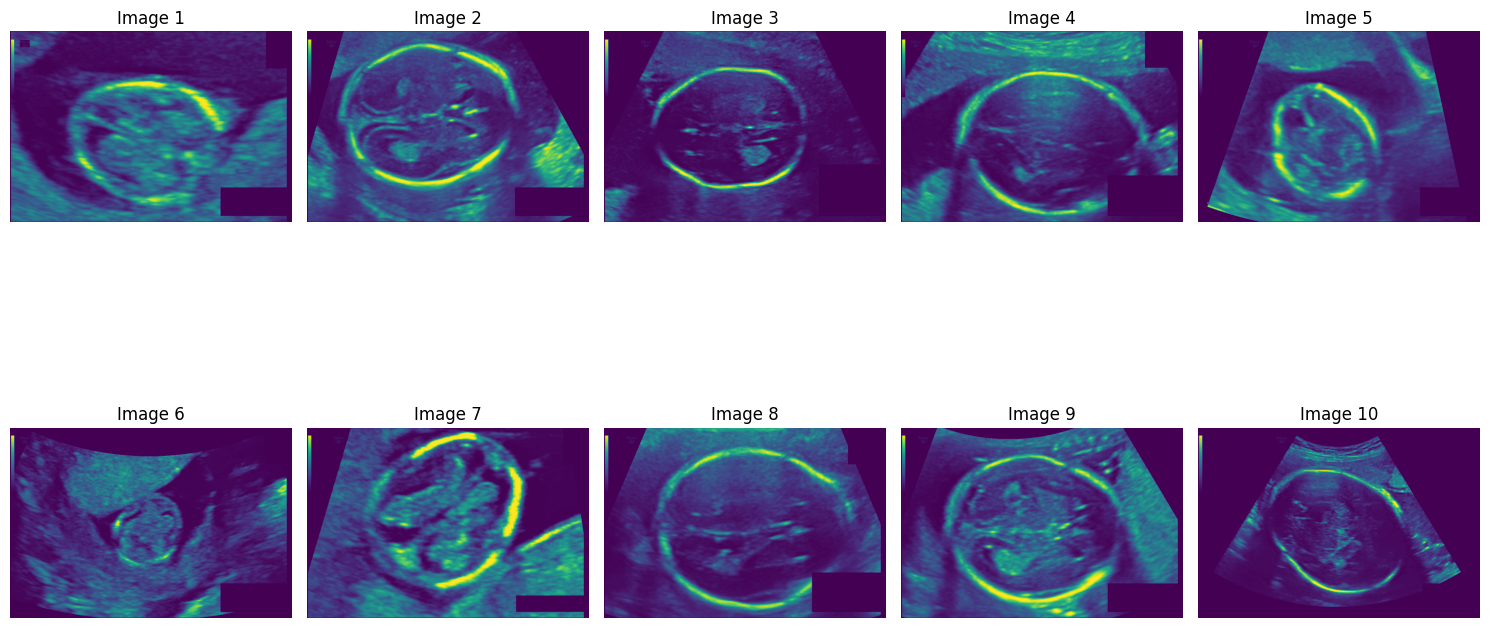

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(15, 10))

for i in range(10):
    img_path = os.path.join(image_folder, image_files[i])
    img = Image.open(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i + 1}')

plt.tight_layout()
plt.show()

In [ ]:
import cv2

In [ ]:
images = []

for file in image_files:
    img_path = os.path.join(image_folder, file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    images.append(img)

images_array = np.array(images)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

features = base_model.predict(preprocess_input(images_array))
features_reshaped = features.reshape(features.shape[0], -1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 364ms/step


In [ ]:
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features_reshaped)

labels = kmeans.labels_

In [ ]:
df = pd.DataFrame({
    'image_path': image_files,
    'cluster_label': labels
})

In [ ]:
df.head()


,image_path,cluster_label
0,020_HC.png,0
1,307_HC.png,2
2,463_HC.png,2
3,574_2HC.png,2
4,135_HC.png,1


In [ ]:
df.tail()

,image_path,cluster_label
994,562_HC.png,1
995,057_HC.png,0
996,230_2HC.png,2
997,686_2HC.png,1
998,350_HC.png,2


In [ ]:
df.shape

(999, 2)

In [ ]:
df.columns

Index(['image_path', 'cluster_label'], dtype='object')

In [ ]:
df['cluster_label'].unique()

array([0, 2, 1], dtype=int32)

In [ ]:
df['cluster_label'].value_counts()

,count
cluster_label,
1,441
2,321
0,237


<ipython-input-25-207ca593be2a>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_clusters, 5, cluster * 5 + i + 1)


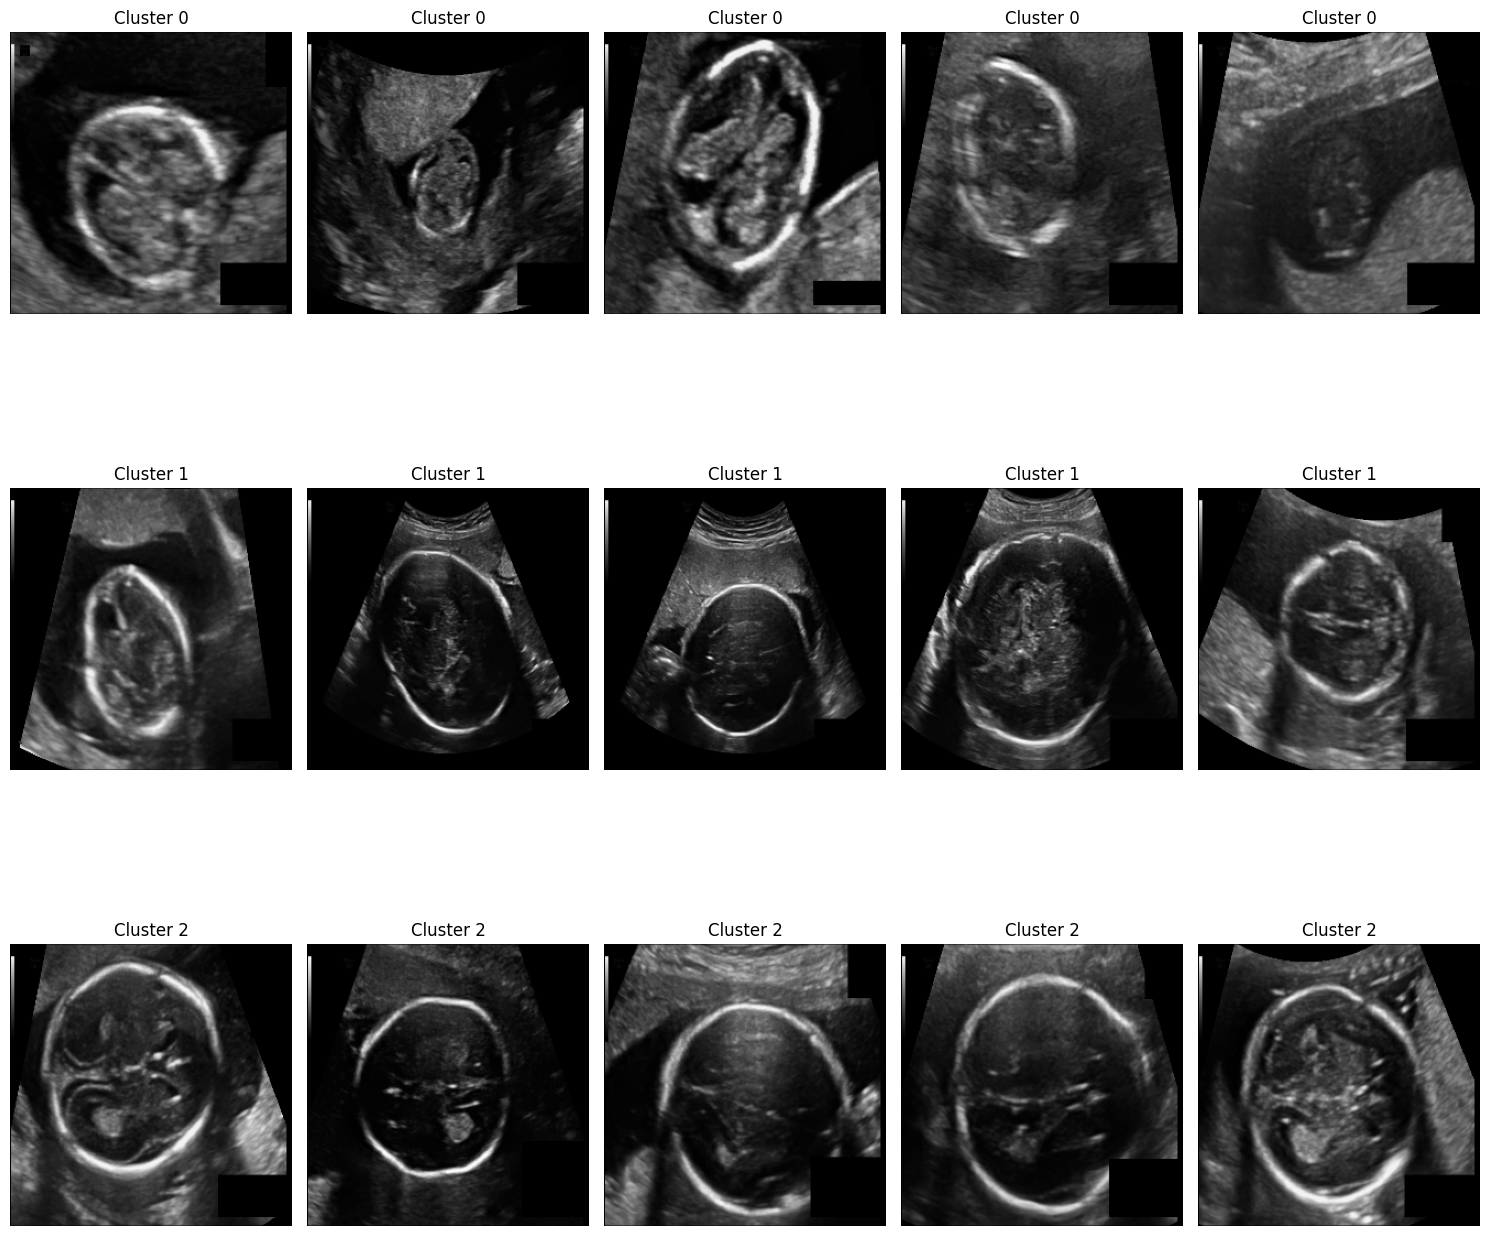

In [ ]:
def plot_clustered_images(df, images_array, n_clusters):
    plt.figure(figsize=(15, 15))
    for cluster in range(n_clusters):
        plt.subplot(n_clusters, 1, cluster + 1)
        cluster_images = df[df['cluster_label'] == cluster]

        for i in range(min(len(cluster_images), 5)):
            img_index = cluster_images.index[i]
            plt.subplot(n_clusters, 5, cluster * 5 + i + 1)
            plt.imshow(images_array[img_index])
            plt.axis('off')
            plt.title(f'Cluster {cluster}')

    plt.tight_layout()
    plt.show()

plot_clustered_images(df, images_array, n_clusters)

In [ ]:
df

,image_path,cluster_label
0,020_HC.png,0
1,307_HC.png,2
2,463_HC.png,2
3,574_2HC.png,2
4,135_HC.png,1
...,...,...
994,562_HC.png,1
995,057_HC.png,0
996,230_2HC.png,2
997,686_2HC.png,1


In [ ]:
df['cluster_label'] = df['cluster_label'].astype(str)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['cluster_label'])

In [ ]:
df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['cluster_label'] = y_resampled

In [ ]:
print("\nClass distribution after oversampling:")
print(df_resampled['cluster_label'].value_counts())


Class distribution after oversampling:
cluster_label
0    441
2    441
1    441
Name: count, dtype: int64


In [ ]:
df_resampled

,image_path,cluster_label
0,020_HC.png,0
1,307_HC.png,2
2,463_HC.png,2
3,574_2HC.png,2
4,135_HC.png,1
...,...,...
1318,618_HC.png,2
1319,561_HC.png,2
1320,619_HC.png,2
1321,441_HC.png,2


In [ ]:
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check kar')

check kar


In [ ]:
df_resampled['cluster_label'] = df_resampled['cluster_label'].astype(str)
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['cluster_label']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['cluster_label']
)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

directory = '/content/extracted_images/Diverse Fetal Head Images-orginal-image'

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    directory=directory,
    x_col='image_path',
    y_col='cluster_label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    directory=directory,
    x_col='image_path',
    y_col='cluster_label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    directory=directory,
    x_col='image_path',
    y_col='cluster_label',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 1058 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.
Found 133 validated image filenames belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [ ]:
def create_cnn_model(input_shape):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    return model

input_shape = (224, 224, 3)

cnn_model = create_cnn_model(input_shape)

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.5339 - loss: 1.0359 - val_accuracy: 0.9470 - val_loss: 0.1913
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9339 - loss: 0.1623 - val_accuracy: 0.9470 - val_loss: 0.1567
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9677 - loss: 0.0962 - val_accuracy: 0.9091 - val_loss: 0.2051
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9873 - loss: 0.0650 - val_accuracy: 0.9470 - val_loss: 0.1900
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9854 - loss: 0.0378 - val_accuracy: 0.9697 - val_loss: 0.1635
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.9996 - loss: 0.0189 - val_accuracy: 0.9470 - val_loss: 0.2468
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9952 - loss: 0.0170 - val_accuracy: 0.9318 - val_loss: 0.3054


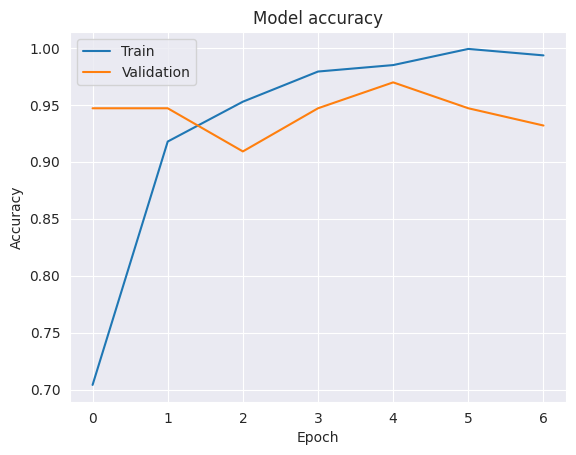

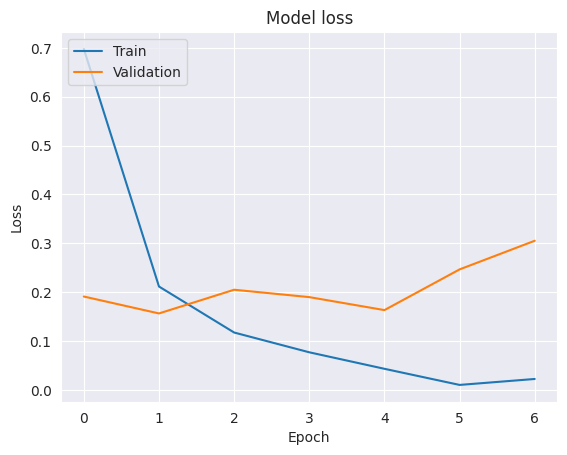

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.91      0.91      0.91        44
           2       0.89      0.89      0.89        45

    accuracy                           0.92       133
   macro avg       0.92      0.92      0.92       133
weighted avg       0.92      0.92      0.92       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

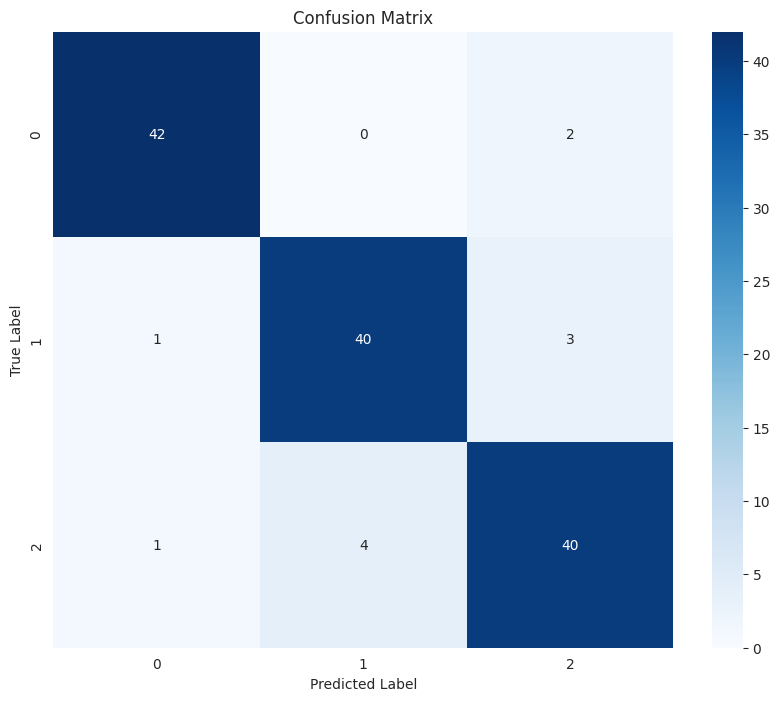

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
def create_inception_model(input_shape):

    base_model = InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False)


    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)

    model.add(GaussianNoise(0.25))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.25))
    model.add(Dropout(0.25))

    model.add(Dense(3, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise

In [ ]:
input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 45s 410ms/step - accuracy: 0.6057 - loss: 0.9568 - val_accuracy: 0.7197 - val_loss: 0.6549
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8655 - loss: 0.3343 - val_accuracy: 0.8788 - val_loss: 0.3164
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9134 - loss: 0.2472 - val_accuracy: 0.9167 - val_loss: 0.2701
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9382 - loss: 0.1883 - val_accuracy: 0.8864 - val_loss: 0.2598
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.9458 - loss: 0.1493 - val_accuracy: 0.9167 - val_loss: 0.2317


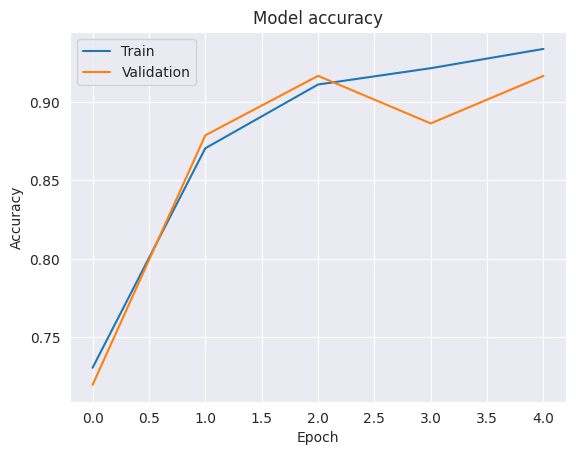

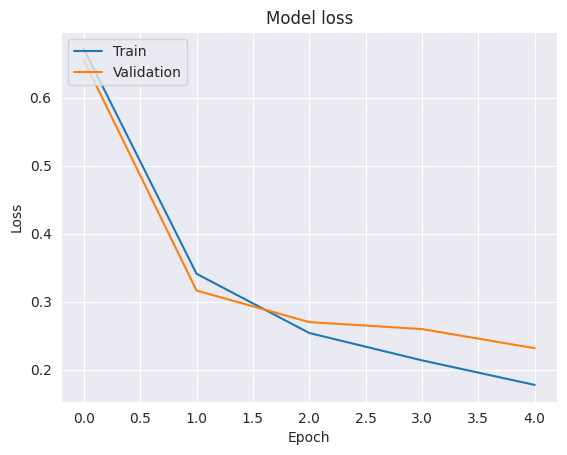

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 906ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        44
           1       0.59      1.00      0.74        44
           2       0.78      0.62      0.69        45

    accuracy                           0.71       133
   macro avg       0.79      0.71      0.70       133
weighted avg       0.79      0.71      0.70       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

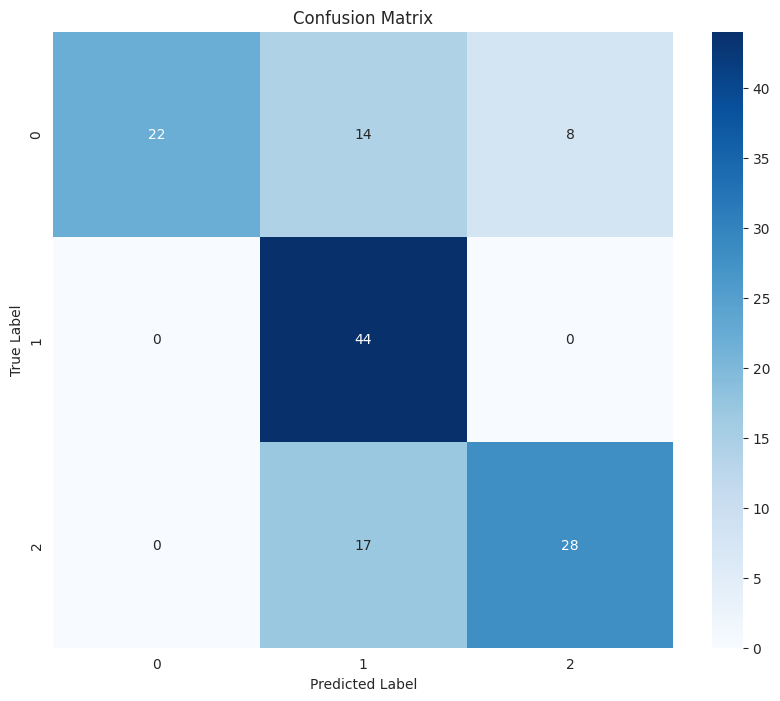

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_xception_model(input_shape):

    base_model = Xception(weights='imagenet', input_shape=input_shape, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GaussianNoise(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(GaussianNoise(0.25))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))

    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.6466 - loss: 0.9025 - val_accuracy: 0.8333 - val_loss: 0.5950
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.8791 - loss: 0.2823 - val_accuracy: 0.8788 - val_loss: 0.3974
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9329 - loss: 0.2022 - val_accuracy: 0.9015 - val_loss: 0.3097
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9248 - loss: 0.1899 - val_accuracy: 0.9242 - val_loss: 0.2340
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9410 - loss: 0.1564 - val_accuracy: 0.9091 - val_loss: 0.2156


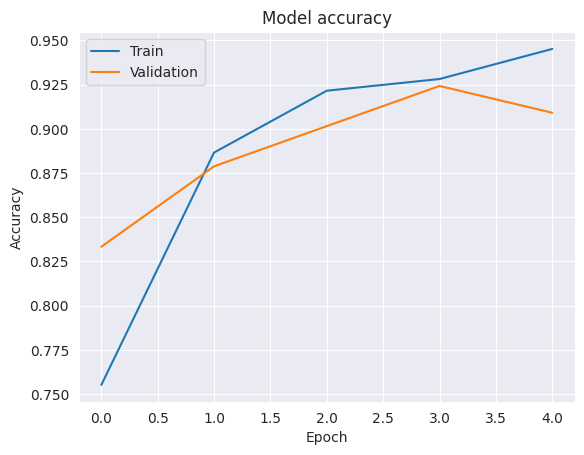

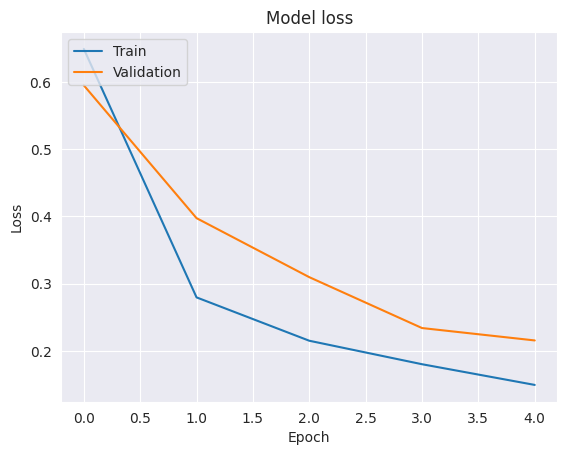

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        44
           1       0.69      0.98      0.81        44
           2       0.74      0.71      0.73        45

    accuracy                           0.77       133
   macro avg       0.81      0.77      0.77       133
weighted avg       0.81      0.77      0.77       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

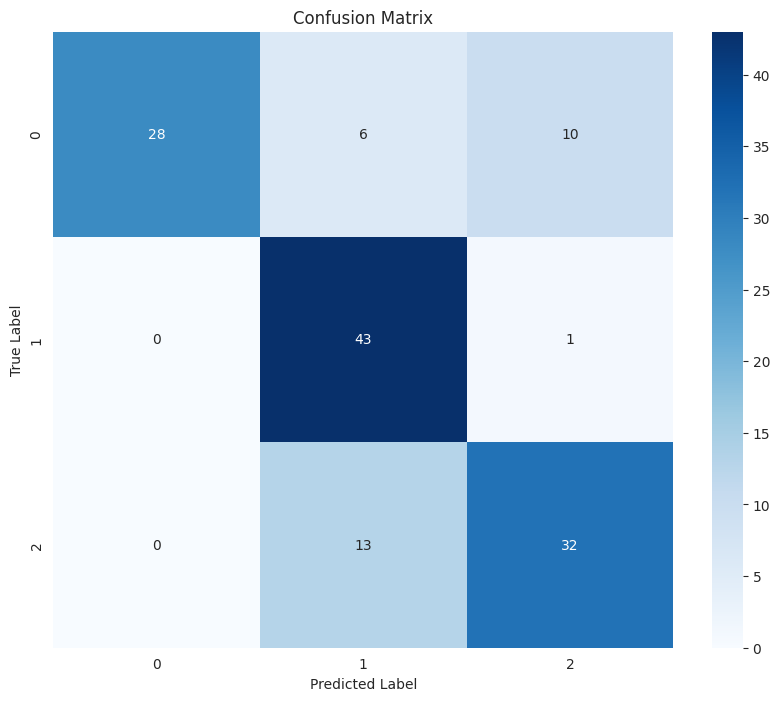

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_xception_model(input_shape):

    inputs = Input(shape=input_shape)

    base_model = Xception(weights='imagenet', input_tensor=inputs, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 7, 7, 2048
    x = Reshape((height * width, channels))(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    attention_output = Reshape((height, width, channels))(attention_output)

    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 46s 433ms/step - accuracy: 0.7900 - loss: 0.6050 - val_accuracy: 0.7576 - val_loss: 0.6027
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.8931 - loss: 0.2771 - val_accuracy: 0.7803 - val_loss: 0.6250
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.9153 - loss: 0.2560 - val_accuracy: 0.8939 - val_loss: 0.2671
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.9307 - loss: 0.1843 - val_accuracy: 0.8636 - val_loss: 0.3659
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step - accuracy: 0.9609 - loss: 0.1169 - val_accuracy: 0.7197 - val_loss: 0.9393


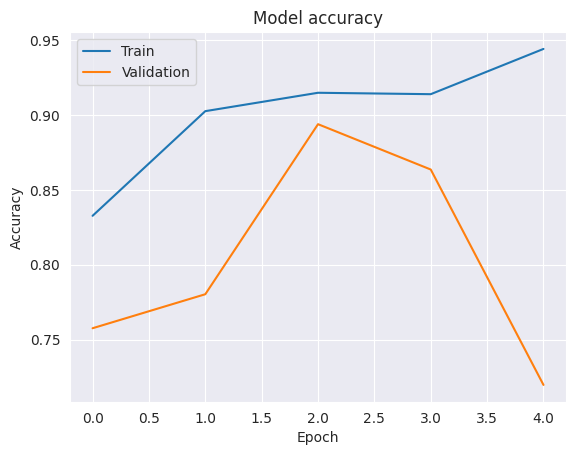

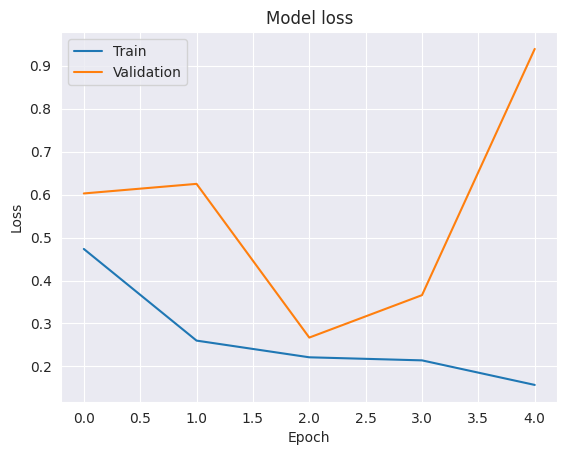

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        44
           1       0.91      0.70      0.79        44
           2       0.54      0.96      0.69        45

    accuracy                           0.70       133
   macro avg       0.82      0.70      0.70       133
weighted avg       0.81      0.70      0.70       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

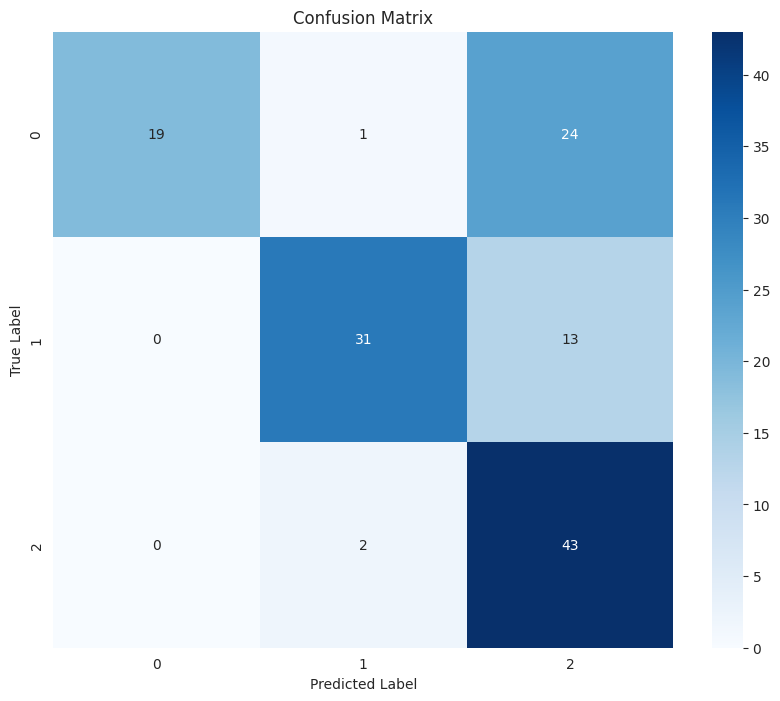

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_inception_model(input_shape):

    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 5, 5, 2048
    x = Reshape((height * width, channels))(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    attention_output = Reshape((height, width, channels))(attention_output)

    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 46s 415ms/step - accuracy: 0.7359 - loss: 0.7223 - val_accuracy: 0.6818 - val_loss: 1.2661
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9110 - loss: 0.2574 - val_accuracy: 0.8485 - val_loss: 0.4088
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.9336 - loss: 0.1716 - val_accuracy: 0.9242 - val_loss: 0.3073
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.9448 - loss: 0.1347 - val_accuracy: 0.8409 - val_loss: 0.5484
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9759 - loss: 0.0773 - val_accuracy: 0.9470 - val_loss: 0.1912


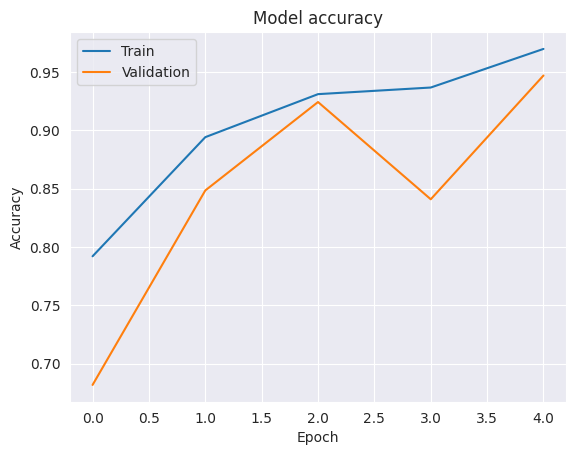

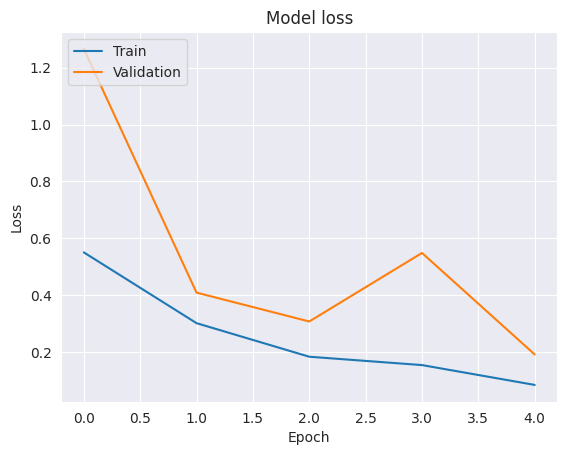

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 857ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       1.00      0.23      0.37        44
           1       0.74      0.98      0.84        44
           2       0.65      0.93      0.76        45

    accuracy                           0.71       133
   macro avg       0.80      0.71      0.66       133
weighted avg       0.79      0.71      0.66       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

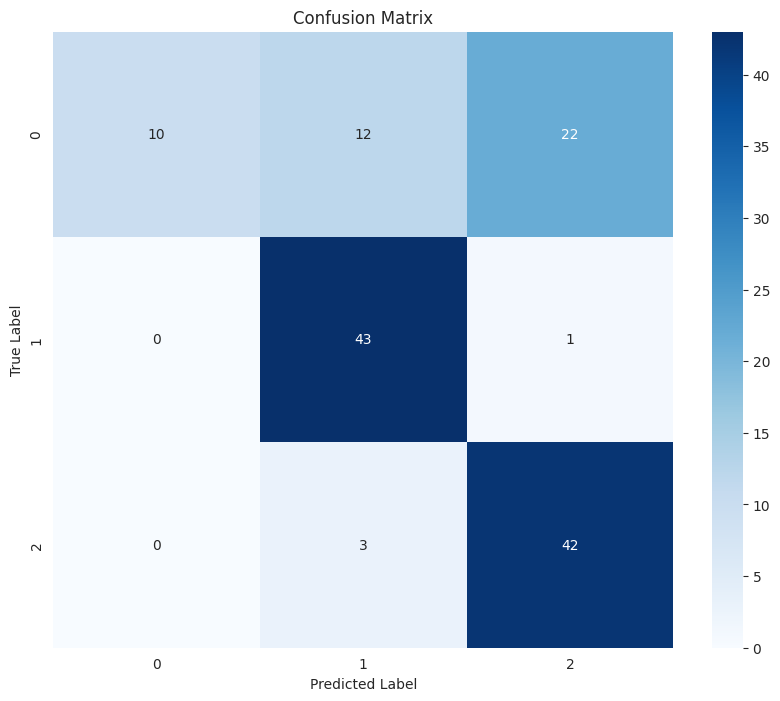

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise, Input, MultiHeadAttention, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_inception_model(input_shape):

    inputs = Input(shape=input_shape)

    base_model = InceptionV3(weights='imagenet', input_tensor=inputs, include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    height, width, channels = 5, 5, 2048
    x = Reshape((height * width, channels))(x)

    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)

    attention_output = Reshape((height, width, channels))(attention_output)

    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

input_shape = (224, 224, 3)
cnn_model = create_inception_model(input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
history = cnn_model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 370ms/step - accuracy: 0.7173 - loss: 0.8067 - val_accuracy: 0.4394 - val_loss: 2.1650
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.8856 - loss: 0.3087 - val_accuracy: 0.8712 - val_loss: 0.4420
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9130 - loss: 0.2236 - val_accuracy: 0.7348 - val_loss: 1.1138
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9678 - loss: 0.1108 - val_accuracy: 0.9167 - val_loss: 0.2292
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.9541 - loss: 0.1652 - val_accuracy: 0.7197 - val_loss: 1.2701


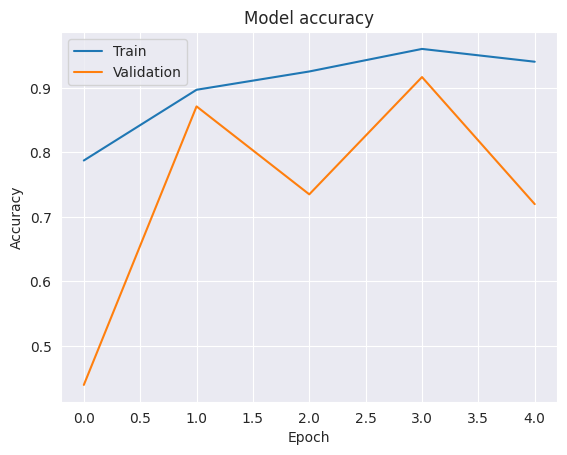

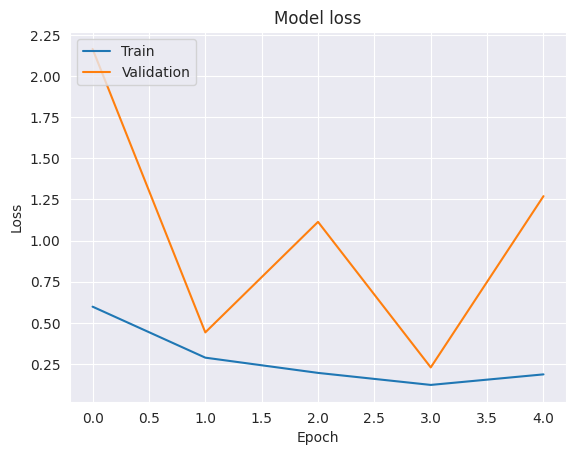

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 757ms/step


In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)


              precision    recall  f1-score   support

           0       1.00      0.09      0.17        44
           1       0.88      0.32      0.47        44
           2       0.40      1.00      0.57        45

    accuracy                           0.47       133
   macro avg       0.76      0.47      0.40       133
weighted avg       0.76      0.47      0.40       133



In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

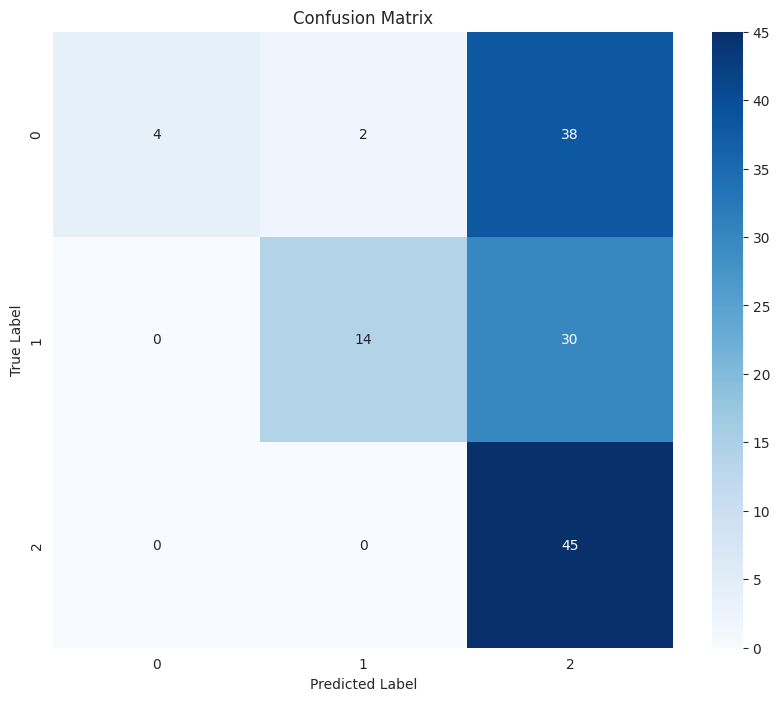

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()